In [38]:
import nltk
import numpy as np
import os
import pandas as pd
import re
from mongoengine import connect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pycoshark.mongomodels import Project, IssueSystem, Issue
from pycoshark.utils import create_mongodb_uri_string
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
project_names = ['ant-ivy', 'archiva', 'calcite', 'cayenne', 'commons-bcel', 'commons-beanutils',
                 'commons-codec', 'commons-collections', 'commons-compress', 'commons-configuration', 
                 'commons-dbcp', 'commons-digester', 'commons-io', 'commons-jcs', 'commons-jexl', 'commons-lang', 
                 'commons-math', 'commons-net', 'commons-rdf', 'commons-scxml', 'commons-validator', 'commons-vfs', 
                 'deltaspike', 'eagle', 'giraph', 'gora', 'jspwiki', 'kylin', 'lens', 'mahout', 'manifoldcf', 
                 'nutch', 'opennlp', 'parquet-mr', 'santuario-java', 'systemml', 'tika', 'wss4j']

In [4]:
project_names[16]

'commons-math'

### Model for multiple projects

In [13]:
frames = []
for i in range(len(project_names)):
    frames.append(pd.read_csv(f'{project_names[i]}.csv'))
# 
df = pd.concat(frames)
df

,Description,Issue type,Title,Label
0,it would be nice to have an includes / exclude...,Improvement,add includes excludes feature in dependencies ...,1
1,fr.jayasoft.ivy.util.Message.error(...); the e...,Bug,Error messages are only displayed when turning...,0
2,When I do a retrieve I would like to tell the ...,New Feature,"Add a ""delete"" parameter to the retrieve task",1
3,It would be sometimes useful to be able to def...,Improvement,possibility to define property in ivyconf.xml,1
4,a stack overflow error occurs when trying to f...,Bug,stack overflow error in some conflicts cases,0
...,...,...,...,...
615,Line 191 and below:\n\n X509Certifi...,Bug,org.apache.ws.security.str.SignatureSTRParser ...,0
616,\nThis JIRA is a placeholder to re-enable test...,Test,Test EncryptedKey elements in the Subject in a...,1
617,\nWSS4J 1.6.x is incorrectly using XML-Securit...,Bug,WSS4J 1.6 incorrectly using XML-Security Resou...,0
618,"running ""mvn"" to build latest stable CXF or la...",Bug,Tests failing with: The signature or decryptio...,0


In [14]:
del frames

In [16]:
#frames[16]

### Download data from .csv

In [162]:
df = pd.read_csv(f'{project_names[16]}.csv')
df

,Description,Issue type,Title,Label
0,/*\n * Copyright 2003-2004 The Apache Software...,Improvement,Adding new methods to RealMatrix,1
1,,Bug,[math] fixed some javadoc and checkstyle warnings,0
2,I did some profiling on a project and found a ...,Bug,[patch] Gamma.logGamma performance,0
3,In MathUtilsTest I found the following code:\n...,Bug,[math] Failure to fail when testing for except...,0
4,Added text to the root finding portion of the ...,Bug,[math] user guide additions - root finding,0
...,...,...,...,...
1403,RealFieldElement in some cases could be used a...,Wish,Make RealFieldElement implement Number,1
1404,When created from boundaries consisting of two...,Bug,PolygonsSet does not handle intersecting infin...,0
1405,The o.a.c.m.geometry.euclidean.twod.PolygonsSe...,Bug,PolygonsSet.getBarycenter() returns incorrect ...,0
1406,I've found an infinite loop when recombining t...,Bug,Infinite loop for CycleCrossover with duplicates,0


In [17]:
df['TitleDescription'] = df['Description'] + ' ' + df['Title']
df

,Description,Issue type,Title,Label,TitleDescription
0,it would be nice to have an includes / exclude...,Improvement,add includes excludes feature in dependencies ...,1,it would be nice to have an includes / exclude...
1,fr.jayasoft.ivy.util.Message.error(...); the e...,Bug,Error messages are only displayed when turning...,0,fr.jayasoft.ivy.util.Message.error(...); the e...
2,When I do a retrieve I would like to tell the ...,New Feature,"Add a ""delete"" parameter to the retrieve task",1,When I do a retrieve I would like to tell the ...
3,It would be sometimes useful to be able to def...,Improvement,possibility to define property in ivyconf.xml,1,It would be sometimes useful to be able to def...
4,a stack overflow error occurs when trying to f...,Bug,stack overflow error in some conflicts cases,0,a stack overflow error occurs when trying to f...
...,...,...,...,...,...
615,Line 191 and below:\n\n X509Certifi...,Bug,org.apache.ws.security.str.SignatureSTRParser ...,0,Line 191 and below:\n\n X509Certifi...
616,\nThis JIRA is a placeholder to re-enable test...,Test,Test EncryptedKey elements in the Subject in a...,1,\nThis JIRA is a placeholder to re-enable test...
617,\nWSS4J 1.6.x is incorrectly using XML-Securit...,Bug,WSS4J 1.6 incorrectly using XML-Security Resou...,0,\nWSS4J 1.6.x is incorrectly using XML-Securit...
618,"running ""mvn"" to build latest stable CXF or la...",Bug,Tests failing with: The signature or decryptio...,0,"running ""mvn"" to build latest stable CXF or la..."


### Preprocessing the data

Bag of words

TF-IDF

In [21]:
desc_title = df['TitleDescription'].tolist()

In [22]:
desc_title[4]

"a stack overflow error occurs when trying to force a revision which isn't the one selected during another conflict resolution. See http://www.jayasoft.org/node/365 for details. stack overflow error in some conflicts cases"

In [23]:
for i in range (len(desc_title)):
    # Convert sentence to lower case
    desc_title[i] = str(desc_title[i]).lower()
    # Remove Numbers
    desc_title[i] = re.sub(r'\d+',' ', desc_title[i])
    # Remove the punctuation and empty spaces from the text
    desc_title[i] = re.sub(r'\W',' ',desc_title[i])
    desc_title[i] = re.sub(r'\s+',' ',desc_title[i])
    # Remove single word in regular expression
    desc_title[i] = re.sub(r'\b[a-zA-Z]\b', '', desc_title[i])

    
desc_title[4]

' stack overflow error occurs when trying to force  revision which isn  the one selected during another conflict resolution see http www jayasoft org node for details stack overflow error in some conflicts cases'

In [24]:
# Remove stop words
stopword = stopwords.words('english')


for i in range(len(desc_title)):
    word_tokens = nltk.word_tokenize(desc_title[i])
    desc_title[i] = [word for word in word_tokens if word not in stopword]

desc_title[4]

['stack',
 'overflow',
 'error',
 'occurs',
 'trying',
 'force',
 'revision',
 'one',
 'selected',
 'another',
 'conflict',
 'resolution',
 'see',
 'http',
 'www',
 'jayasoft',
 'org',
 'node',
 'details',
 'stack',
 'overflow',
 'error',
 'conflicts',
 'cases']

In [25]:
desc_title[4][1]

'overflow'

In [26]:
# Stemming
stemmer= PorterStemmer()

for i in range(len(desc_title)):
    for j in range(len(desc_title[i])):
        desc_title[i][j] = stemmer.stem(desc_title[i][j])
    #for word in desc_issue_types[i][0]:
        
        #print(stemmer.stem(word))
        
desc_title[4]

['stack',
 'overflow',
 'error',
 'occur',
 'tri',
 'forc',
 'revis',
 'one',
 'select',
 'anoth',
 'conflict',
 'resolut',
 'see',
 'http',
 'www',
 'jayasoft',
 'org',
 'node',
 'detail',
 'stack',
 'overflow',
 'error',
 'conflict',
 'case']

In [27]:
# Lemmatization

lemmatizer = WordNetLemmatizer()

for i in range(len(desc_title)):
    for j in range(len(desc_title[i])):
        desc_title[i][j] = lemmatizer.lemmatize(desc_title[i][j])

desc_title[4]


['stack',
 'overflow',
 'error',
 'occur',
 'tri',
 'forc',
 'revis',
 'one',
 'select',
 'anoth',
 'conflict',
 'resolut',
 'see',
 'http',
 'www',
 'jayasoft',
 'org',
 'node',
 'detail',
 'stack',
 'overflow',
 'error',
 'conflict',
 'case']

In [31]:
#title = ([df['Description'].tolist(), df['Issue type'].tolist(), df['Title'].tolist()])

In [34]:
#len(df['Description'].tolist())

1538

In [32]:
#len(title)

3

In [28]:
# Convert list to a string 
       
desc_title_string = []
for i in range(len(desc_title)):
    s = ' '.join(str(word) for word in desc_title[i])
    desc_title_string.append(s)  
    #desc_title_string.append([s, title[i][1]])  

In [29]:
desc_title_string[4]

'stack overflow error occur tri forc revis one select anoth conflict resolut see http www jayasoft org node detail stack overflow error conflict case'

In [30]:
df['DescriptionTitle'] = desc_title_string

In [139]:
#df2 = df.drop(['TitleDescription'], axis=1)
df2 = df2[['Description', 'Title', 'DescriptionTitle', 'Issue type', 'Label']]
df2

,Description,Title,DescriptionTitle,Issue type,Label
0,it would be nice to have an includes / exclude...,add includes excludes feature in dependencies ...,would nice includ exclud artifact depend descr...,Improvement,1
1,fr.jayasoft.ivy.util.Message.error(...); the e...,Error messages are only displayed when turning...,fr jayasoft ivi util messag error error method...,Bug,0
2,When I do a retrieve I would like to tell the ...,"Add a ""delete"" parameter to the retrieve task",retriev would like tell task delet artifact re...,New Feature,1
3,It would be sometimes useful to be able to def...,possibility to define property in ivyconf.xml,would sometim use abl defin ivi variabl direct...,Improvement,1
4,a stack overflow error occurs when trying to f...,stack overflow error in some conflicts cases,stack overflow error occur tri forc revis one ...,Bug,0
...,...,...,...,...,...
39512,Line 191 and below:\n\n X509Certifi...,org.apache.ws.security.str.SignatureSTRParser ...,line certif foundcert secref getx issuerseri c...,Bug,0
39513,\nThis JIRA is a placeholder to re-enable test...,Test EncryptedKey elements in the Subject in a...,jira placehold enabl test specif process saml ...,Test,1
39514,\nWSS4J 1.6.x is incorrectly using XML-Securit...,WSS4J 1.6 incorrectly using XML-Security Resou...,w incorrectli use xml secur resourceresolv res...,Bug,0
39515,"running ""mvn"" to build latest stable CXF or la...",Tests failing with: The signature or decryptio...,run mvn build latest stabl cxf latest trunk cx...,Bug,0


In [32]:
df.to_csv (f'first_38.csv', index = None, header=True) 


In [5]:
df = pd.read_csv('first_38.csv')

In [25]:
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['DescriptionTitle'], df['Label'], random_state=1,
                                                    test_size=0.25)
print(f'Size of the training subset: {len(X_test)}')

# #np.where(pd.isna(X_train))
# X_train.drop
# y_train.iloc[3467]
# X_train = X_train[pd.notnull(X_train)]
# X_test = X_test[pd.notnull(X_test)]

Size of the training subset: 29637


In [27]:
tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf =tfidf.transform(X_test)

In [7]:
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['DescriptionTitle'], df['Label'], random_state=1,
                                                    test_size=0.25)
print(f'Size of the training subset: {len(X_train)}')

tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf =tfidf.transform(X_test)

Size of the training subset: 29637


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [31]:
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Label'], random_state=1,
                                                    test_size=0.25)

print(f'Size of the training subset: {len(X_train)}')

# Remove stop word, change to lowercase, etc. 
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

Size of the training subset: 29637


In [56]:
df_ant_ivy = pd.read_csv('ant-ivy.csv')
df_ant_ivy

,Description,Issue type,Title,Label
0,it would be nice to have an includes / exclude...,Improvement,add includes excludes feature in dependencies ...,1
1,fr.jayasoft.ivy.util.Message.error(...); the e...,Bug,Error messages are only displayed when turning...,0
2,When I do a retrieve I would like to tell the ...,New Feature,"Add a ""delete"" parameter to the retrieve task",1
3,It would be sometimes useful to be able to def...,Improvement,possibility to define property in ivyconf.xml,1
4,a stack overflow error occurs when trying to f...,Bug,stack overflow error in some conflicts cases,0
...,...,...,...,...
1533,according to http://www.apache.org/dev/release...,Task,publish sha512 sums with releases,1
1534,"When resolving a version, Ivy gets an HTML lis...",Bug,Ivy skips entries in URL list where URL is enc...,0
1535,"Hi,\r\n\r\nWe have 40+ modules, for some of mo...",Bug,resolve loops and throws StackOverflowError,0
1536,[https://github.com/apache/ant-ivy/blob/9003b5...,Bug,URLHandlerDispatcher Class description is misl...,0


In [ ]:
# Split the data to training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df['DescriptionTitle'], df['Label'], random_state=1,
                                                    test_size=0.25)
print(f'Size of the training subset: {len(X_train)}')


tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf =tfidf.transform(X_test)

### Training the model

In [75]:
tf_acc = []
cv_acc = []

In [82]:
# Naive Bayes model
naive_bayes = MultinomialNB()

# Training
naive_bayes.fit(X_train_tf, y_train)

# Testing
predictions = naive_bayes.predict(X_test_tf)

In [83]:
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

#tf_acc.append(accuracy_score(y_test, predictions))
#cv_acc.append(accuracy_score(y_test, predictions))

Accuracy score:  0.7767992711812937
Precision score:  0.7807959570435882
Recall score:  0.7610837438423645
F1 score: 0.7708138447146867


In [125]:
# Random Forest model
rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train_cv, y_train)

predictions = rfc.predict(X_test_cv)

C:\Users\Zorigto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [126]:
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

#tf_acc.append(accuracy_score(y_test, predictions))
#cv_acc.append(accuracy_score(y_test, predictions))

Accuracy score:  0.7340823970037453
Precision score:  0.7692492204365555
Recall score:  0.6582512315270936
F1 score: 0.7094347970357262


In [107]:
elastic = LogisticRegression() 

elastic.fit(X_train_cv, y_train)

predictions = elastic.predict(X_test_cv)

In [108]:
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

#tf_acc.append(accuracy_score(y_test, predictions))
#cv_acc.append(accuracy_score(y_test, predictions))

Accuracy score:  0.7863144042919323
Precision score:  0.7645142747652807
Recall score:  0.8189655172413793
F1 score: 0.7908036864532753


In [ ]:
# KNN mb?

In [55]:
# # SV model
# svc = svm.SVC()

# svc.fit(X_train_tf, y_train)

# predictions = svc.predict(X_test_tf)

### Bar plot

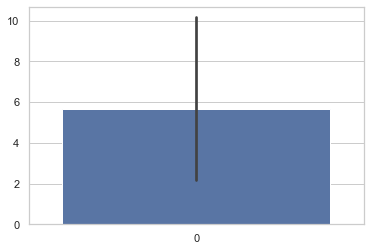

In [71]:
import seaborn as sns

sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
a = np.array([1, 2, 3, 4, 8, 16])

df_a = pd.DataFrame(a)

ax = sns.barplot(data=df_a)
#type(tips)

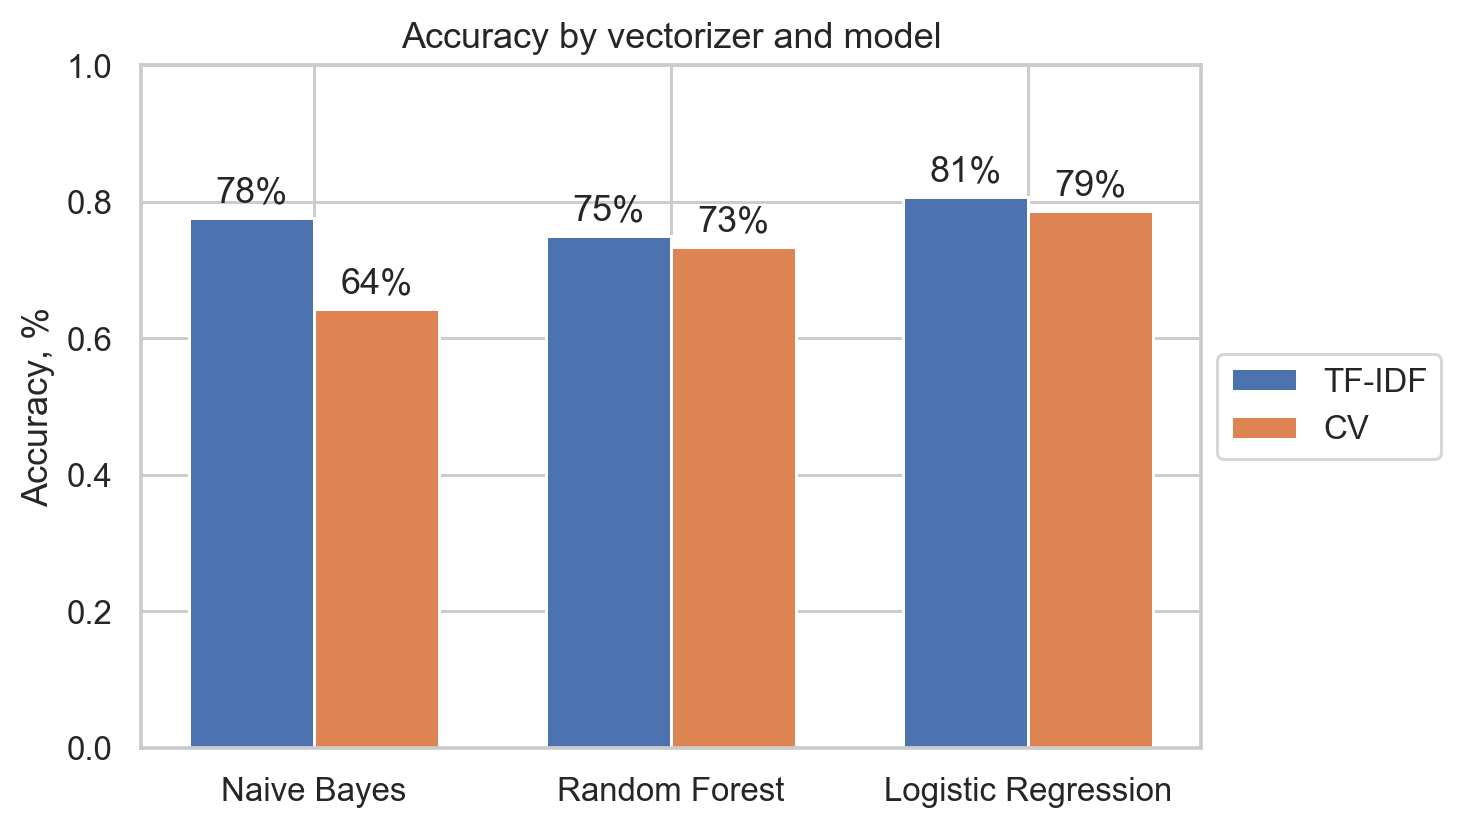

In [101]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Naive Bayes', 'Random Forest', 'Logistic Regression']
#tf_acc = [77, 80, 74, 50, 50]
#cv_acc = [64, 78, 76, 50, 50]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=216)
rects1 = ax.bar(x - width/2, tf_acc, width, label='TF-IDF')
rects2 = ax.bar(x + width/2, cv_acc, width, label='CV')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy, %')
ax.set_title('Accuracy by vectorizer and model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 'right')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(0, 1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.0f}%'.format(height*100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Testing the trained model

In [135]:
test = [['Hello I think I have found a bug', 'Improvement']]
df_test = pd.DataFrame(test, columns =['Description', 'Issue type']) 
df_test['Label'] = df_test['Issue type'].apply(lambda x: 0 if x=='Bug' else 1)
df_test

,Description,Issue type,Label
0,Hello I think I have found a bug,Improvement,1


In [136]:
x_test = cv.transform(df_test['Description'])

# # Naive Bayes model
# naive_bayes = MultinomialNB()

# # Training
# naive_bayes.fit(X_train_cv, y_train)

# # Testing
# predictions = naive_bayes.predict(X_test_cv)

print('Input: ', df_test['Description'][0])
if rfc.predict(x_test)[0] == 0:
    print('Result: This is a bug')
else:
    print('Result: This is not a bug')
print(f'Bug probability: {rfc.predict_proba(x_test)[0,0]}')

Input:  Hello I think I have found a bug
Result: This is a bug
Bug probability: 1.0


In [117]:
print(df_test['Description'][0])

Hey guys I think I have found an error or bug or fail


### TODO

- Add new features to a model (extract them from title, creator_id)

These features can be next:
- Count specific words: (errors, warnings etc.)
- Author bug to other_issue_type ratio (bug to non-bug ratio)
- Count elements of code ( {}, _, // etc.)


- Find good parameters (we can use MinMaxScaler)
- Use several models for the final prediction, make a Pipeline
- Use different projects

In [120]:
a = X_train_tf.toarray()

In [125]:
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
b = X_test_tf.toarray()

In [127]:
# Random Forest model
rfc = RandomForestClassifier(random_state=0)

rfc.fit(a, y_train)

predictions = rfc.predict(b)

C:\Users\Zorigto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
rfc.fit(X_test_tf, y_train)

In [116]:
X_train_tf.shape

(1056, 5364)

In [118]:
y_train.shape

(1056,)

In [128]:
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions)) 

Accuracy score:  0.7130681818181818
Precision score:  0.7391304347826086
Recall score:  0.7195767195767195
F1 score: 0.7292225201072385


In [139]:
for s in df['Description'][:10]:
    print(s[:20])

/*
 * Copyright 2003
 
I did some profiling
In MathUtilsTest I f
Added text to the ro
Add PolynomialFuncti
Index: src/java/org/
RealMatrix (and so R
MathUtils.round(39.2
Patch adds the chang


In [150]:
error_count = []
for i in range(len(df['TitleDescription'])):
    error_count.append(df['TitleDescription'][i].count('bug'))
    
len(error_count)

1408

In [217]:
error_train, error_test, y_train, y_test = train_test_split(error_count, df3['Label'], random_state=1,
                                                    test_size=0.25)
print(f'Size of the training subset: {len(error_train)}')

Size of the training subset: 1056


In [218]:
len(error_train)

1056

In [173]:
X_train_tf.toarray().shape

(1056, 5364)

In [210]:
X_with_errors = np.column_stack([X_train_cv.toarray(), np.asarray(error_train)])

In [211]:
X_test_with_errors = np.column_stack([X_test_cv.toarray(), np.asarray(error_test)])

In [195]:
X_train_tf.max()

0.9984609185615991

In [197]:
X_train_cv.max()

199

In [219]:
# Naive Bayes model
naive_bayes = MultinomialNB()

# Training
naive_bayes.fit(X_with_errors, y_train)

# Testing
predictions = naive_bayes.predict(X_test_with_errors)

In [220]:
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

Accuracy score:  0.7073863636363636
Precision score:  0.7087378640776699
Recall score:  0.7724867724867724
F1 score: 0.7392405063291139
